### Imports

In [1]:
from scipy.optimize import linprog
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

### Problem 1

Problem for linprog should be in the form:

$$
\begin{align} \min_{x} & \quad c^T x \\ \text{s.t.} 
& \quad A_{ub} x \leq b_{ub} \\ 
& \quad A_{eq} x = b_{eq} \\
& \quad l \leq x \leq u

\end{align}
$$

Where $c$, $A_{ub}$, $b_{ub}$, $A_{eq}$, $b_{eq}$ are (numpy) arrays.

In [2]:
# coefficients of linear objective function to be minimized
c = [-3, -2]
A = [[2, 1], 
     [1, 1],
     [1, 0]]
b_ub = [10, 8, 4]

# bounds on variables (x0, x1). By default, all variables are non-negative 
# (so this is redundant, but included for clarity)
x0_bounds = (0, None)
x1_bounds = (0, None)

Find solution

In [3]:
res = linprog(c, A_ub=A, b_ub=b_ub, bounds=[x0_bounds, x1_bounds])
print(res)

           con: array([], dtype=float64)
 crossover_nit: 0
         eqlin:  marginals: array([], dtype=float64)
  residual: array([], dtype=float64)
           fun: -18.0
       ineqlin:  marginals: array([-1., -1., -0.])
  residual: array([0., 0., 2.])
         lower:  marginals: array([0., 0.])
  residual: array([2., 6.])
       message: 'Optimization terminated successfully. (HiGHS Status 7: Optimal)'
           nit: 2
         slack: array([0., 0., 2.])
        status: 0
       success: True
         upper:  marginals: array([0., 0.])
  residual: array([inf, inf])
             x: array([2., 6.])


Visualize solution

Based on steps explained here: https://machinelearningmastery.com/visualization-for-function-optimization-in-python/

In [4]:
# objective function
def objective(x, c):
    return c[0] * x[0] + c[1] * x[1]

# define range for input
r_min, r_max = 0, 10

# sample input range uniformly at 0.1 increments
x0axis = np.arange(r_min, r_max, 0.01)
x1axis = np.arange(r_min, r_max, 0.01)

# create a mesh from the axis
x1, x2 = np.meshgrid(x0axis, x1axis)
x_plt = np.stack((x1, x2), axis=0)

# compute targets
results = objective(x_plt, c)

In [5]:
# plot feasible region based on A, b_ub
def compute_region(A, b_ub, x1, x2):
    region = np.zeros_like(x1)
    for i in range(len(A)):
        region += (A[i][0]*x1 + A[i][1]*x2 <= b_ub[i]).astype(int)
    # if all constraints are satisfied, then the point is in the feasible region
    return (region == len(A)).astype(int)        

def plot_constraints(A, b_ub, zorder=0):
    for i in range(len(A)):  
        # plot constraints as contour lines
        cnt = plt.contour(x1, x2, A[i][0]*x1 + A[i][1]*x2 - b_ub[i], levels=[0], colors='black', zorder=zorder)
        
        # label constraints
        plt.clabel(cnt, inline=True, fontsize=10, fmt={0: f'g{i+1}(x)'})        

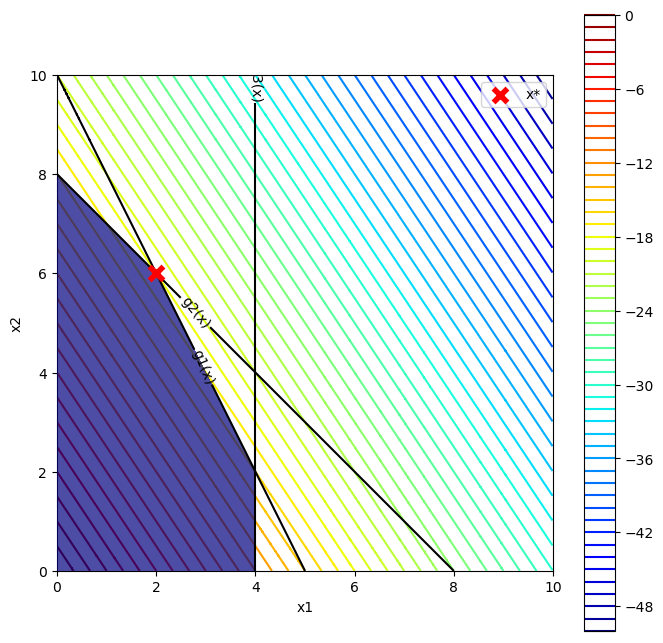

In [6]:
# create a contour plot with 50 levels and jet color scheme
plt.figure(figsize=(8, 8))
plt.contour(x1, x2, results, 50, alpha=1.0, cmap=plt.cm.jet)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()

# get list of python colors
colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# plot the constraints
plot_constraints(A, b_ub, zorder=10)

# plot the feasible region
region = compute_region(A, b_ub, x1, x2)
masked_region = np.ma.masked_where(region == 0, region)

plt.imshow(masked_region, extent=(x1.min(), x1.max(), x2.min(), x2.max()), 
           origin="lower", cmap="jet", alpha = 0.7, zorder=5, interpolation='none')

# plot the results
plt.scatter(res.x[0], res.x[1], color='red', zorder=11, label='x*', marker='x', s=100, linewidth=4)

# limit the plot to the range
plt.xlim(r_min, r_max)
plt.ylim(r_min, r_max)
plt.legend()
plt.show()

### Problem 2

In [7]:
# solve problem 2 using cvxpy

# variable x is a 2-dimensional vector
x = cp.Variable(2)

# define constraints
A = [[2, 1], 
     [1, 1],
     [1, 0]]
A = np.array(A)

b_ub = [10, 8, 4]
constraints = [A @ x <= b_ub]

# define objective function
obj = cp.Minimize((x[0] - 5)**2 + (x[1] - 5)**2)

# define and solve the problem
prob = cp.Problem(obj, constraints)
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value)

status: optimal
optimal value 5.0000000000000036
optimal var [3. 4.]


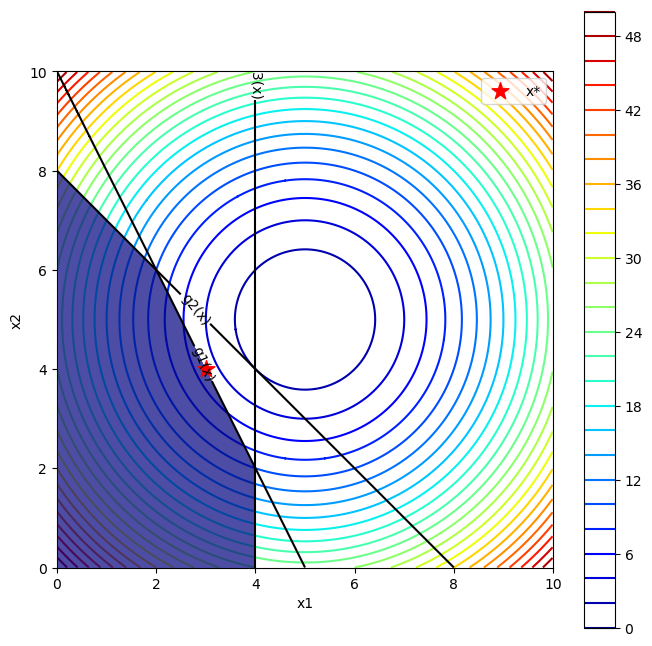

In [8]:
# new objective function
def objective(x):
    return (x[0] - 5)**2 + (x[1] - 5)**2

# compute targets
results = objective(x_plt)

# new contour plot
plt.figure(figsize=(8, 8))
plt.contour(x1, x2, results, 25, alpha=1.0, cmap=plt.cm.jet)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()

# plot the constraints
plot_constraints(A, b_ub, zorder=10)

# plot the feasible region
region = compute_region(A, b_ub, x1, x2)
masked_region = np.ma.masked_where(region == 0, region)

plt.imshow(masked_region, extent=(x1.min(), x1.max(), x2.min(), x2.max()), 
           origin="lower", cmap="jet", alpha = 0.7, zorder=5, interpolation='none')

# plot the results
plt.scatter(x.value[0], x.value[1], color='red', zorder=11, label='x*', marker='*', s=160, linewidth=1)

# limit the plot to the range
plt.xlim(r_min, r_max)
plt.ylim(r_min, r_max)
plt.legend()
plt.show()

### Problem 3

In [9]:
from scipy.optimize import minimize, NonlinearConstraint

# define objective function
def obj(x):
    return 0.5*x[0]**2 + 0.5*x[1]**2

# define non-linear constraint
con = lambda x:  x[0] * x[1] - 4
nlc = NonlinearConstraint(con, 0, 0)

# define bounds (x must be positive)
bnds = ((0, None), (0, None))

# initial guess
x0 = [3, 4]

# solve problem
res = minimize(obj, x0, bounds=bnds, constraints=nlc, method='SLSQP')
print(res)

     fun: 3.9999997811279018
     jac: array([2.00005317, 1.99994677])
 message: 'Optimization terminated successfully'
    nfev: 15
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([2.00005313, 1.99994676])


### Problem 4

In [10]:
# rosenbrock's banana function
def rosenbrock(x):
    return (1-x[0])**2 + 100*(x[1]-x[0]**2)**2

# solve problem
x0 = [-1, 1]
res = minimize(rosenbrock, x0, method='SLSQP')
print(res)

     fun: 1.1590160244161364e-09
     jac: array([-0.03584476,  0.01754801])
 message: 'Optimization terminated successfully'
    nfev: 127
     nit: 37
    njev: 37
  status: 0
 success: True
       x: array([0.99996596, 0.9999319 ])
